In [1]:
# imports
from matplotlib import pyplot as plt
import pandas as pd
from hmmlearn import hmm
import numpy as np
import sys
import time
sys.path.insert(1, '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/')


import cleaner
import filter
from kalman import KalmanFilter

wsl = True

In [2]:
if wsl:
    parent = '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/.data'
else:
    parent = ".data"
data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [3]:
cleaner.print_structure(data_dict)


  train: 
 	 t_gps: 
 		 PVS 1: (1458, 11)
 		 PVS 2: (1551, 11)
 		 PVS 3: (1316, 11)
 		 PVS 4: (1432, 11)
 		 PVS 5: (1263, 11)
 		 PVS 6: (915, 11)
 	 gps_mpu_left: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 gps_mpu_right: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 labels: 
 		 PVS 1: (144036, 14)
 		 PVS 2: (124684, 14)
 		 PVS 3: (105816, 14)
 		 PVS 4: (132492, 14)
 		 PVS 5: (133877, 14)
 		 PVS 6: (96279, 14)
 	 folders: 6
  val: 
 	 t_gps: 
 		 PVS 9: (999, 11)
 	 gps_mpu_left: 
 		 PVS 9: (91555, 26)
 	 gps_mpu_right: 
 		 PVS 9: (91555, 26)
 	 labels: 
 		 PVS 9: (91555, 14)
 	 folders: 1
  test: 
 	 t_gps: 
 		 PVS 7: (1281, 11)
 		 PVS 8: (1134, 11)
 	 gps_mpu_left: 
 		 PVS 7: (128548, 26)
 		 PVS 8: (123618, 26)
 	 gps_mpu_right: 
 		 PVS 7: (128548, 26)
 		 PVS 8:

In [ ]:
filter.add_smoothed_cols(data_dict, window=200)

In [ ]:
filter.add_diff_cols(data_dict)

In [6]:
len(data_dict["train"]["t_gps"]["PVS 1"])

1458

In [88]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index
        if road == "good_road_left":
            # also add indices where "regular_road_left" is 1
            reg_labels = df[type]["labels"][folder]["regular_road_left"]
            indices = indices.append(reg_labels[reg_labels == 1].index)

        new_data = pvsi.loc[indices]["acc_z_dash_smooth"]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)           
    return result - 9.8, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    # "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    # "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

val_dict = {
    "good": build_z_dash(data_dict, type="val", road="good_road_left"),
    # "regular": build_z_dash(data_dict, type="val", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="val", road="bad_road_left")
}

# HMM

I got it to run (it turns out that you can only include one series as your input data) but it doesn't work. I think the HMM decided that zeros are local minimums or values below a threshold and pretty much everything else is ones.

In [13]:
model_list = []
n_list = range(2, 9)
for nc in n_list:
    print(f"\n{nc} components:")
    models = {}
    num_models = 2
    for key in train_dict.keys():
        # make data an array
        data, lengths = train_dict[key]
        data = data.values.reshape(-1, 1)
        print(key, end=": ")

        best_log = -np.inf
        best_model = None
        for i in range(num_models):
            # Initialize and train the model
            model = hmm.GMMHMM(n_components=nc, covariance_type="diag")
            model.fit(data, lengths=lengths)
            # Check the log-likelihood
            log_likelihood = model.monitor_.history[-1]
            if log_likelihood > best_log:
                best_log = log_likelihood
                best_model = model
            print(i, end=", ")
        models[key] = best_model
    
    model_list.append(models)


2 components:
good: 0, 1, bad: 0, 1, 
3 components:
good: 0, 1, bad: 0, 1, 
4 components:
good: 0, 1, bad: 0, 1, 
5 components:
good: 0, 1, bad: 0, 1, 
6 components:
good: 0, 1, bad: 0, 1, 
7 components:
good: 0, 1, bad: 0, 1, 
8 components:
good: 0, 1, bad: 0, 1, 

In [48]:
# predicted_labels = model.predict(X)

def predict(mfcc_coeffs, index):
    """
    Predict the word from the given mfcc coefficients
    
    Parameters
    ----------
    mfcc_coeffs : ndarray of shape (M,)
        The mfcc coefficients for the word to be predicted
    index : int
        The index of the model in the list of models
        
    Returns
    -------
    word : str
        The predicted word
    """
    # find the log probability density of the given mfcc coefficients
    log_prob = {}
    for key in model_list[index].keys():
        log_prob[key] = model_list[index][key].score(mfcc_coeffs)
    
    # return the class with the highest probability
    return max(log_prob, key=log_prob.get)



time_window = 10 # seconds
time_window *= 1000
n_list = range(2, 9)

for j, nc in enumerate(n_list):
    print("Number of components:", nc)
    for key in test_dict.keys():
        correct = 0
        incorrect = 0
        test_data, _ = test_dict[key]

        # iterate over test_data in groups of 10000
        test_data = test_data.values.reshape(-1, 1)
        for i in range(0, len(test_data), time_window):
            item = test_data[i:i+time_window]
            prediction = predict(item, j)
            if prediction == key:
                correct += 1
            # elif prediction == "good" and key == "regular":
            #     correct += 1
            # elif prediction == "regular" and key == "good":
            #     correct += 1
            else:
                incorrect += 1
        
        print("Accuracy for", key, ":", correct/(correct+incorrect))
    print()

Number of components: 2
Accuracy for good : 0.9047619047619048
Accuracy for bad : 0.0

Number of components: 3
Accuracy for good : 0.2857142857142857
Accuracy for bad : 0.5

Number of components: 4
Accuracy for good : 0.7142857142857143
Accuracy for bad : 0.0

Number of components: 5
Accuracy for good : 0.09523809523809523
Accuracy for bad : 0.8333333333333334

Number of components: 6
Accuracy for good : 0.047619047619047616
Accuracy for bad : 1.0

Number of components: 7
Accuracy for good : 0.9047619047619048
Accuracy for bad : 0.0

Number of components: 8
Accuracy for good : 0.047619047619047616
Accuracy for bad : 1.0



In [49]:
best = {"good": model_list[5]["good"], 
        "bad": model_list[6]["bad"]}

In [63]:
def best_predict(mfcc_coeffs):
    log_prob = {}
    for key in best.keys():
        log_prob[key] = best[key].score(mfcc_coeffs)
    return max(log_prob, key=log_prob.get)

time_window = 10000
preds = []
corrects = []
for key in test_dict.keys():
    correct = 0
    incorrect = 0
    test_data, _ = test_dict[key]

    # iterate over test_data in groups of 10000
    test_data = test_data.values.reshape(-1, 1)
    for i in range(0, len(test_data), time_window):
        item = test_data[i:i+time_window]
        prediction = best_predict(item)
        ith = 0 if prediction == "good" else 1
        jth = 0 if key == "good" else 1
        preds.append([ith for _ in range(time_window)])
        corrects.append([jth for _ in range(time_window)])
        if prediction == key:
            correct += 1
        else:
            incorrect += 1
    
    print("Accuracy for", key, ":", correct/(correct+incorrect))

Accuracy for good : 0.5714285714285714
Accuracy for bad : 0.3333333333333333


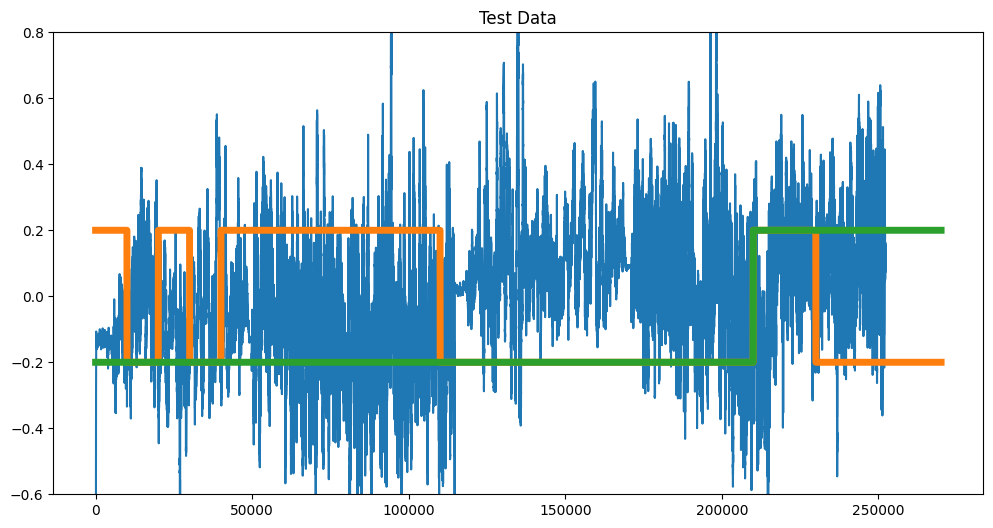

In [91]:
# plot test data
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate([test_dict["good"][0].values, test_dict["bad"][0].values]))
plt.plot(np.array(preds).flatten()*0.4 - 0.2, linewidth=5)
plt.plot(np.array(corrects).flatten()*0.4 - 0.2, linewidth=5)
plt.title("Test Data")
plt.ylim(-0.6, 0.8)
plt.show()

Low is good and high is bad

In [18]:
def pretty_print_parameters(parameters):
    for key, value in parameters.items():
        if isinstance(value, str):
            print(f"{key}: '{value}'")
        elif isinstance(value, bool):
            print(f"{key}: {str(value).lower()}")
        elif isinstance(value, (int, float)):
            print(f"{key}: {value}")
        elif isinstance(value, list):
            print(f"{key}:")
            for sub_value in value:
                if isinstance(sub_value, list):
                    for sub_sub_value in sub_value:
                        print(f"  - {sub_sub_value}")
                else:
                    print(f"  - {sub_value}")
        elif isinstance(value, np.ndarray):
            print(f"{key}:")
            for sub_value in value:
                for sub_sub_value in sub_value:
                    print(f"  - {sub_sub_value}")
        else:
            print(f"{key}: {value}")

def compare_parameter_sets(parameters1, parameters2):
    max_key_length = max(len(key) for key in parameters1.keys())

    print("Parameters Set 1".ljust(max_key_length + 15), "Parameters Set 2")
    print("-" * (max_key_length + 15), " " * 5, "-" * max_key_length)

    for key in parameters1.keys():
        value1 = parameters1[key]
        value2 = parameters2[key] if key in parameters2 else None

        if isinstance(value1, (int, float, str, bool)):
            print(f"{key}: {str(value1).ljust(max_key_length)}", " " * 5, f"{key}: {value2}")
        elif isinstance(value1, list):
            print(f"{key}:")
            for sub_value1, sub_value2 in zip(value1, value2 or []):
                print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
        elif isinstance(value1, np.ndarray):
            print(f"{key}:")
            if value2 is not None and value1.shape == value2.shape:
                flattened_value1 = value1.flatten()
                flattened_value2 = value2.flatten()
                for sub_value1, sub_value2 in zip(flattened_value1, flattened_value2):
                    print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
            else:
                print("  Arrays are not of the same shape or one of them is None")
        else:
            print(f"{key}: {value1}", " " * 5, f"{key}: {value2}")


for _n in range(len(model_list)):
    good_params = model_list[_n]["good"].get_params()
    bad_params = model_list[_n]["bad"].get_params()
    print(f"\nModel {_n + 2} components\n")
    compare_parameter_sets(good_params, bad_params)


Model 2 components

Parameters Set 1               Parameters Set 2
------------------------------       ---------------
algorithm: viterbi               algorithm: viterbi
covariance_type: diag                  covariance_type: diag
covars_prior:
  - -1.5                    - -1.5
  - -1.5                    - -1.5
covars_weight:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
implementation: log                   implementation: log
init_params: stmcw                 init_params: stmcw
means_prior:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
means_weight:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
min_covar: 0.001                 min_covar: 0.001
n_components: 2                     n_components: 2
n_iter: 10                    n_iter: 10
n_mix: 1                     n_mix: 1
params: stmcw                 params: stmcw
random_state: None       random_state: None
startprob_prior: 1.0                   startprob_prior